## Questions to Answer
1. Does Filtering on noise estimates worsen imbalance? Before vs after IR for CLNI, Two-stage ensemble
2. Avg. noise likelihood of minority vs majority class?
3. Ratio of 0->1 & 1->0 noise types vs ratio of noisy samples identified in each class. With oracle access to no of actual, total no. of noisy samples 

In [1]:
import numpy as np,os
import pandas as pd
from sklearn.metrics import matthews_corrcoef, precision_recall_curve, auc, accuracy_score, precision_score, recall_score
import seaborn as sns,matplotlib.pyplot as plt

from library.utils import evaluate, read_data
from library.cleaners import kDN, ih_prob

/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Notes
+ Using `kDN(K=5)`: In `25/32` datasets, no of samples with NP noise (Bug class in noisy dataset but actually Clean) has been overestimated. Consequently PN has been underestimated. This shows minority class gets disproportionately affected.
    + For `ih_prob`: that number is `23/32`
+ In terms of avg. probability of being noisy: samples in Bug class (of noisy data version) have vastly hugher value than clean ones. On further avg on 32 datasets, `.702 vs .074`, almost 10 times higher.

In [2]:
DATASETS = ['groovy-1_5_7.csv','jruby-1.4.0.csv','lucene-2.9.0.csv','jruby-1.7.0.preview1.csv','groovy-1_6_BETA_1.csv',
        'derby-10.2.1.6.csv','wicket-1.5.3.csv','camel-2.9.0.csv','camel-1.4.0.csv','activemq-5.8.0.csv']
DATASETS = [f for f in os.listdir("JIRA/") if 'csv' in f]
len(DATASETS)

32

In [3]:
df = pd.DataFrame(index=DATASETS,columns=['PN','ePN','NP','eNP','avg-bug','avg-clean'])
for d in DATASETS:
    X,y_noisy,y_real = read_data(d,True)
    PN = y_noisy[y_real==1]==0   #So, really 1(P), but now 0(N)
    NP = y_noisy[y_real==0]==1   #So, really 0(N), but now 1(P)
    assert PN.sum()+NP.sum()==(y_noisy!=y_real).sum()
    print(f"PN {PN.sum()},NP {NP.sum()}")
    ne = kDN(X,y_noisy,K=5)
    avg_bug,avg_clean = ne[y_noisy==1].mean(),ne[y_noisy==0].mean()  #avg_bug: avg noise probs of those labelled Buggy in Noisy dataset
    actual_total = (y_noisy!=y_real).sum()
    nidx = np.argsort(ne)[-actual_total:]
    eNP = y_noisy[nidx]==1
    ePN = y_noisy[nidx]==0
    print(f"ePN {ePN.sum()},eNP {eNP.sum()}")
    print(f"Avg, Bug:{avg_bug:.3f}, Clean:{avg_clean:.3f}")
    print()
    df.loc[d,:] = [x.sum() for x in [PN,ePN,NP,eNP]] + [avg_bug,avg_clean]

activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)
PN 100,NP 97
ePN 26,eNP 171
Avg, Bug:0.790, Clean:0.045

groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
PN 29,NP 76
ePN 39,eNP 66
Avg, Bug:0.525, Clean:0.092

activemq-5.3.0.csv noise:0.094, imb:15.669,142,2225, Shape:(2367, 65)
PN 169,NP 53
ePN 88,eNP 134
Avg, Bug:0.782, Clean:0.042

wicket-1.3.0-incubating-beta-1.csv noise:0.164, imb:4.806,288,1384, Shape:(1672, 65)
PN 44,NP 231
ePN 86,eNP 189
Avg, Bug:0.608, Clean:0.123

jruby-1.1.csv noise:0.175, imb:3.540,161,570, Shape:(731, 65)
PN 27,NP 101
ePN 59,eNP 69
Avg, Bug:0.442, Clean:0.154

jruby-1.4.0.csv noise:0.190, imb:3.890,200,778, Shape:(978, 65)
PN 83,NP 103
ePN 66,eNP 120
Avg, Bug:0.566, Clean:0.139

lucene-2.3.0.csv noise:0.204, imb:4.031,160,645, Shape:(805, 65)
PN 100,NP 64
ePN 62,eNP 102
Avg, Bug:0.601, Clean:0.139

hbase-0.95.2.csv noise:0.260, imb:15.088,114,1720, Shape:(1834, 65)
PN 423,NP 54
ePN 363,eNP 114
Avg, Bug:0.821, Clean

KeyboardInterrupt: 

In [9]:
df

,PN,ePN,NP,eNP,avg-bug,avg-clean
activemq-5.8.0.csv,100,25,97,172,0.790148,0.0452596
groovy-1_6_BETA_1.csv,29,40,76,65,0.523077,0.0923295
activemq-5.3.0.csv,169,88,53,134,0.78169,0.0420674
wicket-1.3.0-incubating-beta-1.csv,44,86,231,189,0.607639,0.122832
jruby-1.1.csv,27,59,101,69,0.442236,0.153684
jruby-1.4.0.csv,83,67,103,119,0.566,0.13856
lucene-2.3.0.csv,100,59,64,105,0.60125,0.138915
hbase-0.95.2.csv,423,363,54,114,0.821053,0.0533721
lucene-3.0.0.csv,106,94,141,153,0.656842,0.117524
camel-2.9.0.csv,156,117,157,196,0.88,0.0215318


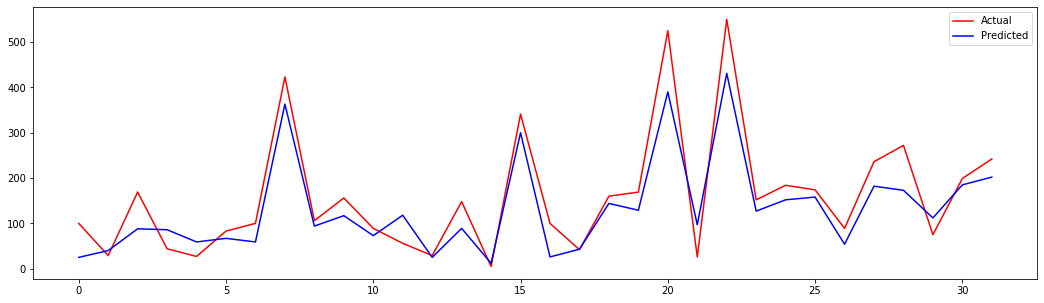

In [10]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['PN'],c='r',label='Actual');
plt.plot(range(len(DATASETS)),df['ePN'],c='b',label='Predicted');
plt.legend();

In [11]:
(df['ePN']>df['PN']).sum(),(df['eNP']>df['NP']).sum()

(8, 24)

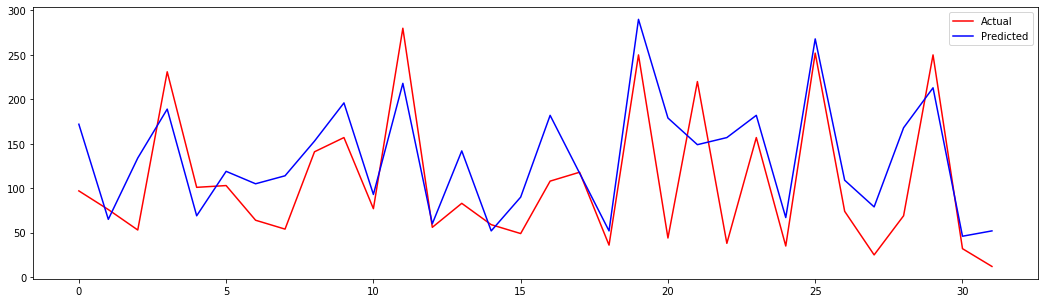

In [12]:
plt.figure(figsize=(18,5))
plt.plot(range(len(DATASETS)),df['NP'],c='r',label='Actual');
plt.plot(range(len(DATASETS)),df['eNP'],c='b',label='Predicted');
plt.legend();

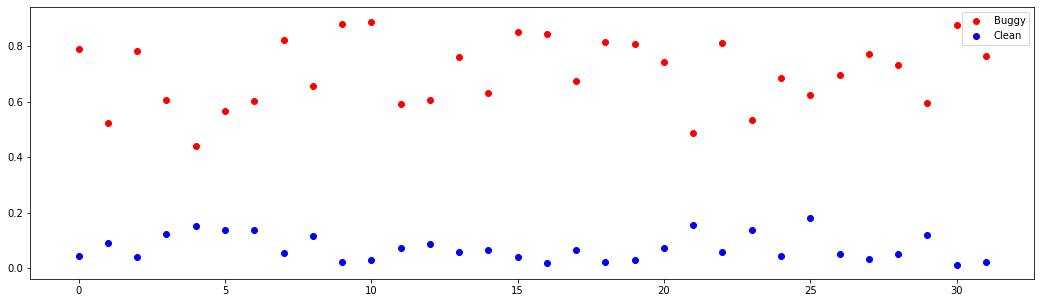

In [16]:
plt.figure(figsize=(18,5))
plt.scatter(range(len(DATASETS)),df['avg-bug'],c='r',label='Buggy');
plt.scatter(range(len(DATASETS)),df['avg-clean'],c='b',label='Clean');
plt.legend();

In [19]:
df['avg-bug'].mean(),df['avg-clean'].mean()

(0.7022098451418166, 0.07364579187376764)

## Impact on Classification performance
So, both noise detectors discriminate against minority Bug class. But when we incorporate this noise estimates into this imbalanced classification setting, how much does this actually hurt classification performance? Is balancing first better? `Balancing->Filtering` vs `Filtering->Balancing`

In [3]:
from collections import defaultdict
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.ensemble import BalancedBaggingClassifier, RUSBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler, EditedNearestNeighbours, TomekLinks
from imblearn.pipeline import Pipeline

from library.cleaners import FilteringEstimator

/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/shihab/anaconda3/envs/ana/lib/python3.7/site-pack

In [4]:
def evaluateFilter(clf,X,y_noisy,y_real,cv,scorers):
    scores = defaultdict(list)
    to_keep = (y_noisy==y_real).sum()
    for train_id, test_id in cv.split(X,y_real):  #vs y_noisy, to solve no-pos-label-in-test-set bug     
        try:
            clf = clf.fit(X[train_id],y_noisy[train_id],to_keep=to_keep)
        except ValueError as e:
            assert str(e).startswith("Expected n_neighbors"),f"Some different Error:{str(e)}"
            for func in scorers:
                scores[func.__name__].append(0)
            print("ERROR")
            continue
        print("TEST SIZE:",X[test_id].shape[0])
        probs = clf.predict_proba(X[test_id])
        labels = np.argmax(probs,axis=1)
        for func in scorers:
            yp = probs[:,1]
            try:
                func([0,1,1],[.2,.6,.7])
                yp = probs[:,1]
            except ValueError as e:
                yp = labels
            scores[func.__name__].append(func(y_real[test_id],yp))
    for func in scorers:
        scores[func.__name__] = np.array(scores[func.__name__])
    return scores

In [5]:
imbs = {
#     'smote': SMOTE(k_neighbors=5),
    'rus': RandomUnderSampler('not minority'),
    'wilson':EditedNearestNeighbours(n_neighbors=5),  #Default was 3
    'tomek': TomekLinks(),
}
clfs = {
#     'dt': DecisionTreeClassifier(max_depth=20),
#     'lr': LogisticRegression(solver='lbfgs',max_iter=1000),
#     'nb': GaussianNB(),
    'knn': KNeighborsClassifier(n_neighbors=5),
    'rf': RandomForestClassifier(n_estimators=50),
}
ensembles = {
    'rboost_DT': RUSBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10),algorithm='SAMME',n_estimators=10),
    'rboost_NB': RUSBoostClassifier(base_estimator=GaussianNB(),algorithm='SAMME',n_estimators=10),
    'bbag_DT': BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,max_features='sqrt')),
    'bbag_NB': BalancedBaggingClassifier(base_estimator=GaussianNB()),
}
simples = {
    'LR': LogisticRegression(solver='lbfgs',max_iter=1000),
    'RF': RandomForestClassifier(n_estimators=50)
}

## Filtering -> Balancing

In [6]:
models = {}
for im,samp in imbs.items():
    for c,clf in clfs.items():
        models[(im,c)] = FilteringEstimator(Pipeline([('samp',samp),('clf',clf)]),kDN,K=5)

for m,ens in ensembles.items():
    models[('ens',m)] = FilteringEstimator(ens,kDN,K=5)
    
for m,clf in simples.items():
    models[('sim',m)] = FilteringEstimator(clf,kDN,K=5)    
    
models.keys(),len(models)

(dict_keys([('rus', 'knn'), ('rus', 'rf'), ('wilson', 'knn'), ('wilson', 'rf'), ('tomek', 'knn'), ('tomek', 'rf'), ('ens', 'rboost_DT'), ('ens', 'rboost_NB'), ('ens', 'bbag_DT'), ('ens', 'bbag_NB'), ('sim', 'LR'), ('sim', 'RF')]),
 12)

In [7]:
cv = RepeatedStratifiedKFold(n_splits=10,n_repeats=1,random_state=42)
def pr_rec_score(y,yp):
    prec, rec, _ = precision_recall_curve(y,yp)
    return auc(rec,prec)
scorers = [matthews_corrcoef,pr_rec_score]

In [8]:
cols = pd.MultiIndex.from_product([imbs.keys(),clfs.keys(),[f.__name__ for f in scorers]],names=['imb','clf','metric'])
df = pd.DataFrame(index=DATASETS,columns=cols)

In [9]:
for k in models:
    print(k)
    for d in DATASETS:
        X,y_noisy,y_real = read_data(d,stats=True)
        r = evaluateFilter(models[k],X,y_noisy,y_real,cv,scorers)
        for f in r:
            df.loc[d,(k[0],k[1],f)] = r[f].mean()

('rus', 'knn')
activemq-5.8.0.csv noise:0.058, imb:15.847,203,3217, Shape:(3420, 65)
(3078, 65) [2891  187] [2891  187]
TEST SIZE: 342
(3078, 65) [2897  181] [2897  181]
TEST SIZE: 342
(3078, 65) [2896  182] [2896  182]
TEST SIZE: 342
(3078, 65) [2892  186] [2892  186]
TEST SIZE: 342
(3078, 65) [2891  187] [2891  187]
TEST SIZE: 342
(3078, 65) [2895  183] [2895  183]
TEST SIZE: 342
(3078, 65) [2895  183] [2895  183]
TEST SIZE: 342
(3078, 65) [2901  177] [2901  177]
TEST SIZE: 342
(3078, 65) [2895  183] [2895  183]
TEST SIZE: 342
(3078, 65) [2900  178] [2900  178]
TEST SIZE: 342
groovy-1_6_BETA_1.csv noise:0.128, imb:6.017,117,704, Shape:(821, 65)
(716, 65) [628  88] [631 107]
TEST SIZE: 83
(716, 65) [632  84] [635 104]
TEST SIZE: 82
(716, 65) [632  84] [635 104]
TEST SIZE: 82
(716, 65) [627  89] [630 109]
TEST SIZE: 82
(716, 65) [629  87] [632 107]
TEST SIZE: 82
(716, 65) [635  81] [636 103]
TEST SIZE: 82
(716, 65) [631  85] [634 105]
TEST SIZE: 82
(716, 65) [629  87] [632 107]
TEST SI

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 5

In [16]:
d = ValueError("Expected n_neighbors <= n_samples,  but n_samples = 5, n_neighbors = 6")

In [18]:
str(d).startswith("Expected n_neighbors")

True